# Tutorial 9 (JAX): Deep Autoencoders 

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial9/AE_CIFAR10.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial9/AE_CIFAR10.ipynb)   
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial9)      
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code.
    
</div>

---

**Speed comparison**: We note the training times for all models in the PyTorch and the JAX implementation below (PyTorch v1.11, JAX v0.3.13). The models were trained on the same hardware (NVIDIA RTX3090, 24 core CPU) and we slightly adjusted the tutorials to use the exact same training settings (same data loading parameters, evaluation schedule, etc.). Overall, the JAX implementation is about *1.7x faster* than PyTorch!
    
| Models           |   PyTorch   |     JAX    |
|------------------|:-----------:|:----------:|
| AE - 64 latents  | 15min 51sec | 7min 13sec |
| AE - 128 latents | 15min 59sec | 7min 13sec |
| AE - 256 latents | 16min 1sec  | 7min 15sec |
| AE - 384 latents | 16min 7sec  | 7min 19sec |

---

In this tutorial, we will take a closer look at autoencoders (AE). Autoencoders are trained on encoding input data such as images into a smaller feature vector, and afterward, reconstruct it by a second neural network, called a decoder. The feature vector is called the "bottleneck" of the network as we aim to compress the input data into a smaller amount of features. This property is useful in many applications, in particular in compressing data or comparing images on a metric beyond pixel-level comparisons. Besides learning about the autoencoder framework, we will also see the "deconvolution" (or transposed convolution) operator in action for scaling up feature maps in height and width. Such deconvolution networks are necessary wherever we start from a small feature vector and need to output an image of full size (e.g. in VAE, GANs, or super-resolution applications). 

First of all, we import most of our standard libraries. We use [JAX](https://jax.readthedocs.io/en/latest/) as acceleration backend, [Flax](https://flax.readthedocs.io/en/latest/index.html) for implementing neural networks, and [Optax](https://optax.readthedocs.io/en/latest/index.html) to optimize the models.

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 
from scipy import spatial

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial9_jax"

print("Device:", jax.devices()[0])

/tmp/ipykernel_1159040/1500918507.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: gpu:0


We have 4 pretrained models that we have to download. Remember the adjust the variables `DATASET_PATH` and `CHECKPOINT_PATH` if needed.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial9/"
# Files to download
pretrained_files = ["cifar10_64.ckpt", "cifar10_128.ckpt", "cifar10_256.ckpt", "cifar10_384.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

In this tutorial, we work with the CIFAR10 dataset. In CIFAR10, each image has 3 color channels and is 32x32 pixels large. As autoencoders do not have the constrain of modeling images probabilistic, we can work on more complex image data (i.e. 3 color channels instead of black-and-white) much easier than for VAEs. 
In case you have downloaded CIFAR10 already in a different directory, make sure to set DATASET_PATH accordingly to prevent another download.

In contrast to previous tutorials on CIFAR10 like [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) (CNN classification), we do not normalize the data explicitly with a mean of 0 and std of 1, but roughly estimate it scaling the data between -1 and 1. This is because limiting the range will make our task of predicting/reconstructing images easier.

In [3]:
# Transformations applied on each image => bring them into a numpy array
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    if img.max() > 1:
        img = img / 255. * 2. - 1.
    return img

# For visualization, we might want to map JAX or numpy tensors back to PyTorch
def jax_to_torch(imgs):
    imgs = jax.device_get(imgs)
    imgs = torch.from_numpy(imgs.astype(np.float32))
    imgs = imgs.permute(0, 3, 1, 2)
    return imgs

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=image_to_numpy, download=True)
train_set, val_set = data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=image_to_numpy, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4, collate_fn=numpy_collate, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4, collate_fn=numpy_collate)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4, collate_fn=numpy_collate)

Files already downloaded and verified
Files already downloaded and verified


## Building the autoencoder

In general, an autoencoder consists of an **encoder** that maps the input $x$ to a lower-dimensional feature vector $z$, and a **decoder** that reconstructs the input $\hat{x}$ from $z$. We train the model by comparing $x$ to $\hat{x}$ and optimizing the parameters to increase the similarity between $x$ and $\hat{x}$. See below for a small illustration of the autoencoder framework.

<center width="100%"><img src="../../tutorial9/autoencoder_visualization.svg" style="display: block; margin-left: auto; margin-right: auto;" width="650px"/></center>

We first start by implementing the encoder. The encoder effectively consists of a deep convolutional network, where we scale down the image layer-by-layer using strided convolutions. After downscaling the image three times, we flatten the features and apply linear layers. The latent representation $z$ is therefore a vector of size *d* which can be flexibly selected. 

In [4]:
class Encoder(nn.Module):
    c_hid : int
    latent_dim : int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 32x32 => 16x16
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 16x16 => 8x8
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 8x8 => 4x4
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], -1)  # Image grid to single feature vector
        x = nn.Dense(features=self.latent_dim)(x)
        return x

In [5]:
## Test encoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example images as input
imgs = next(iter(train_loader))[0]
# Create encoder
encoder = Encoder(c_hid=32, latent_dim=128)
# Initialize parameters of encoder with random key and images
params = encoder.init(rng, imgs)['params']
# Apply encoder with parameters on the images
out = encoder.apply({'params': params}, imgs)
out.shape

del out, encoder, params

Note that we do not apply Batch Normalization here. This is because we want the encoding of each image to be independent of all the other images. Otherwise, we might introduce correlations into the encoding or decoding that we do not want to have. In some implementations, you still can see Batch Normalization being used, because it can also serve as a form of regularization. Nevertheless, the better practice is to go with other normalization techniques if necessary like Instance Normalization or Layer Normalization. Given the small size of the model, we can neglect normalization for now.

The decoder is a mirrored, flipped version of the encoder. The only difference is that we replace strided convolutions by transposed convolutions (i.e. deconvolutions) to upscale the features. Transposed convolutions can be imagined as adding the stride to the input instead of the output, and can thus upscale the input. For an illustration of a `nn.ConvTranspose` layer with kernel size 3, stride 2, and padding 1, see below (figure credit - [Vincent Dumoulin and Francesco Visin](https://arxiv.org/abs/1603.07285)):

<center width="100%"><img src="../../tutorial9/deconvolution.gif" width="250px"></center>

You see that for an input of size $3\times3$, we obtain an output of $5\times5$. However, to truly have a reverse operation of the convolution, we need to ensure that the layer scales the input shape by a factor of 2 (e.g. $4\times4\to8\times8$). Flax already has this as a default setting for the padding, so we do not need to adjust anything here.

Overall, the decoder can be implemented as follows:

In [6]:
class Decoder(nn.Module):
    c_out : int
    c_hid : int
    latent_dim : int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*16*self.c_hid)(x)
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], 4, 4, -1)
        x = nn.ConvTranspose(features=2*self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_out, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.tanh(x)
        return x

In [7]:
## Test decoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example latents as input
rng, lat_rng = random.split(rng)
latents = random.normal(lat_rng, (16, 128))
# Create decoder
decoder = Decoder(c_hid=32, latent_dim=128, c_out=3)
# Initialize parameters of decoder with random key and latents
rng, init_rng = random.split(rng)
params = decoder.init(init_rng, latents)['params']
# Apply decoder with parameters on the images
out = decoder.apply({'params': params}, latents)
out.shape

del out, decoder, params

The encoder and decoder networks we chose here are relatively simple. Usually, more complex networks are applied, especially when using a ResNet-based architecture. For example, see [VQ-VAE](https://arxiv.org/abs/1711.00937) and [NVAE](https://arxiv.org/abs/2007.03898) (although the papers discuss architectures for VAEs, they can equally be applied to standard autoencoders). 

In a final step, we add the encoder and decoder together into the autoencoder architecture.

In [8]:
class Autoencoder(nn.Module):
    c_hid: int
    latent_dim : int
        
    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = Encoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        self.decoder = Decoder(c_hid=self.c_hid, latent_dim=self.latent_dim, c_out=3)
        
    def __call__(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [9]:
## Test Autoencoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example images as input
imgs = next(iter(train_loader))[0]
# Create encoder
autoencoder = Autoencoder(c_hid=32, latent_dim=128)
# Initialize parameters of encoder with random key and images
params = autoencoder.init(rng, imgs)['params']
# Apply encoder with parameters on the images
out = autoencoder.apply({'params': params}, imgs)
out.shape

del out, autoencoder, params

For the loss function, we use the mean squared error (MSE), which we implement below:

In [10]:
def mse_recon_loss(model, params, batch):
    imgs, _ = batch
    recon_imgs = model.apply({'params': params}, imgs)
    loss = ((recon_imgs - imgs) ** 2).mean(axis=0).sum()  # Mean over batch, sum over pixels
    return loss

The mean squared error pushes the network to pay special attention to those pixel values its estimate is far away. Predicting 127 instead of 128 is not important when reconstructing, but confusing 0 with 128 is much worse. Note that in contrast to VAEs, we do not predict the probability per pixel value, but instead use a distance measure. This saves a lot of parameters and simplifies training. To get a better intuition per pixel, we report the summed squared error averaged over the batch dimension (any other mean/sum leads to the same result/parameters). 

However, MSE has also some considerable disadvantages. Usually, MSE leads to blurry images where small noise/high-frequent patterns are removed as those cause a very low error. To ensure realistic images to be reconstructed, one could combine Generative Adversarial Networks (lecture 10) with autoencoders as done in several works (e.g. see [here](https://arxiv.org/abs/1704.02304), [here](https://arxiv.org/abs/1511.05644) or these [slides](http://elarosca.net/slides/iccv_autoencoder_gans.pdf)). Additionally, comparing two images using MSE does not necessarily reflect their visual similarity. For instance, suppose the autoencoder reconstructs an image shifted by one pixel to the right and bottom. Although the images are almost identical, we can get a higher loss than predicting a constant pixel value for half of the image (see code below). An example solution for this issue includes using a separate, pre-trained CNN, and use a distance of visual features in lower layers as a distance measure instead of the original pixel-level comparison.

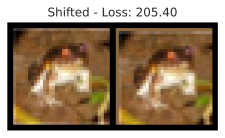

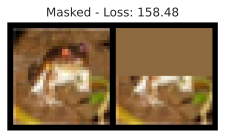

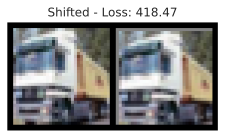

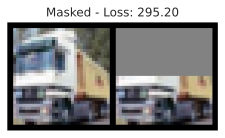

In [11]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = ((img1 - img2) ** 2).sum()
    # Plot images for visual comparison
    imgs = jax_to_torch(np.stack([img1, img2], axis=0))
    grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(axis=(0,1), keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = np.roll(img, shift=SHIFT, axis=0)
    img_shifted = np.roll(img_shifted, shift=SHIFT, axis=1)
    img_shifted[:1,:,:] = img_mean
    img_shifted[:,:1,:] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = np.copy(img)
    img_masked[:img_masked.shape[1]//2,:,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

### Training the model

During the training, we want to keep track of the learning progress by seeing reconstructions made by our model. For this, we implement a callback object which will add reconstructions every $N$ epochs to our tensorboard. To align it with the PyTorch tutorial version, we implement it similar to how we would do it in PyTorch Lightning:

In [12]:
class GenerateCallback:
    
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs  # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def log_generations(self, model, state, logger, epoch):
        if epoch % self.every_n_epochs == 0:
            reconst_imgs = model.apply({'params': state.params}, self.input_imgs)
            reconst_imgs = jax.device_get(reconst_imgs)

            # Plot and add to tensorboard
            imgs = np.stack([self.input_imgs, reconst_imgs], axis=1).reshape(-1, *self.input_imgs.shape[1:])
            imgs = jax_to_torch(imgs)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, value_range=(-1,1))
            logger.add_image("Reconstructions", grid, global_step=epoch)

Further, to train multiple models with different hyperparameters, we summarize all training functionalities in a trainer object below:

In [13]:
class TrainerModule:
    
    def __init__(self, c_hid, latent_dim, lr=1e-3, seed=42):
        super().__init__()
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.lr = lr
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = Autoencoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        # Prepare logging
        self.exmp_imgs = next(iter(val_loader))[0][:8]
        self.log_dir = os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}')
        self.generate_callback = GenerateCallback(self.exmp_imgs, every_n_epochs=50)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model()
        
    def create_functions(self):
        # Training function 
        def train_step(state, batch):
            loss_fn = lambda params: mse_recon_loss(self.model, params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)  # Get loss and gradients for loss
            state = state.apply_gradients(grads=grads)  # Optimizer update step
            return state, loss
        self.train_step = jax.jit(train_step)
        # Eval function
        def eval_step(state, batch):
            return mse_recon_loss(self.model, state.params, batch)
        self.eval_step = jax.jit(eval_step)
        
    def init_model(self):
        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        rng, init_rng = jax.random.split(rng)
        params = self.model.init(init_rng, self.exmp_imgs)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=1e-3,
            warmup_steps=100,
            decay_steps=500*len(train_loader),
            end_value=1e-5
        )
        optimizer = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)
        
    def train_model(self, num_epochs=500):
        # Train model for defined number of epochs
        best_eval = 1e6
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 10 == 0:
                eval_loss = self.eval_model(val_loader)
                self.logger.add_scalar('val/loss', eval_loss, global_step=epoch_idx)
                if eval_loss < best_eval:
                    best_eval = eval_loss
                    self.save_model(step=epoch_idx)
                self.generate_callback.log_generations(self.model, self.state, logger=self.logger, epoch=epoch_idx)
                self.logger.flush()
                
    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss
        losses = []
        for batch in train_loader:
            self.state, loss = self.train_step(self.state, batch)
            losses.append(loss)
        losses_np = np.stack(jax.device_get(losses))
        avg_loss = losses_np.mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        
    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        losses = []
        batch_sizes = []
        for batch in data_loader:
            loss = self.eval_step(self.state, batch)
            losses.append(loss)
            batch_sizes.append(batch[0].shape[0])
        losses_np = np.stack(jax.device_get(losses))
        batch_sizes_np = np.stack(batch_sizes)
        avg_loss = (losses_np * batch_sizes_np).sum() / batch_sizes_np.sum()
        return avg_loss
    
    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_', step=step)
        
    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_')
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)
        
    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}.ckpt'))

We will now write a training function that allows us to train the autoencoder with different latent dimensionality and returns the test score. We provide pre-trained models and recommend you using those, especially when you work on a computer without GPU. Of course, feel free to train your own models.

In [14]:
def train_cifar(latent_dim):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(c_hid=32, latent_dim=latent_dim)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(num_epochs=500)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    test_loss = trainer.eval_model(test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, test_loss

### Comparing latent dimensionality

When training an autoencoder, we need to choose a dimensionality for the latent representation $z$. The higher the latent dimensionality, the better we expect the reconstruction to be. However, the idea of autoencoders is to *compress* data. Hence, we are also interested in keeping the dimensionality low. To find the best tradeoff, we can train multiple models with different latent dimensionalities. The original input has $32\times 32\times 3 = 3072$ pixels. Keeping this in mind, a reasonable choice for the latent dimensionality might be between 64 and 384:

In [15]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    trainer_ld, test_loss_ld = train_cifar(latent_dim)
    model_dict[latent_dim] = {"trainer": trainer_ld, "result": test_loss_ld}

After training the models, we can plot the reconstruction loss over the latent dimensionality to get an intuition how these two properties are correlated:

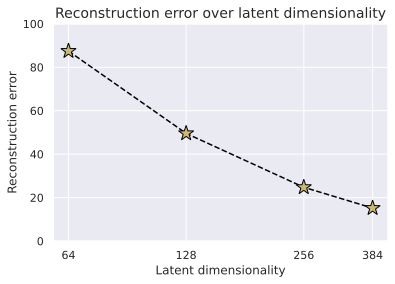

In [16]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

As we initially expected, the reconstruction loss goes down with increasing latent dimensionality. For our model and setup, the two properties seem to be exponentially (or double exponentially) correlated. To understand what these differences in reconstruction error mean, we can visualize example reconstructions of the four models: 

In [17]:
def visualize_reconstructions(trainer, input_imgs):
    # Reconstruct images
    reconst_imgs = trainer.model_bd(input_imgs)
    imgs = np.stack([input_imgs, reconst_imgs], axis=1).reshape(-1, *reconst_imgs.shape[1:])
    
    # Plotting
    imgs = jax_to_torch(imgs)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {trainer.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

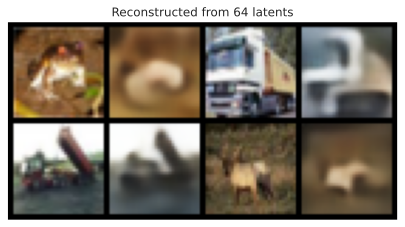

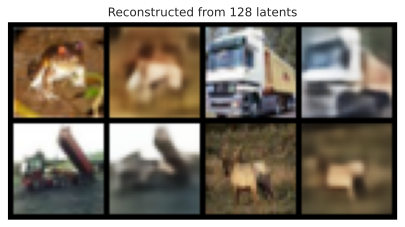

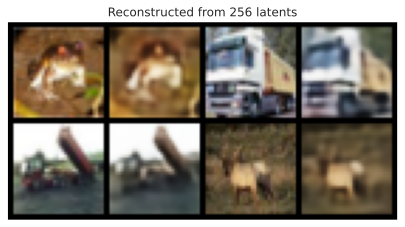

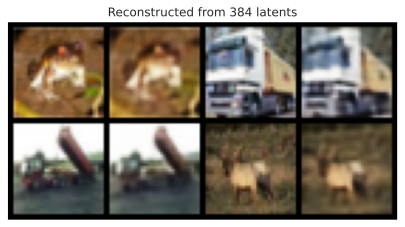

In [18]:
input_imgs = np.stack([image_to_numpy(train_dataset[i][0]) for i in range(4)], axis=0)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["trainer"], input_imgs)

Clearly, the smallest latent dimensionality can only save information about the rough shape and color of the object, but the reconstructed image is extremely blurry and it is hard to recognize the original object in the reconstruction. With 128 features, we can recognize some shapes again although the picture remains blurry. The models with the highest two dimensionalities reconstruct the images quite well. The difference between 256 and 384 is marginal at first sight but can be noticed when comparing, for instance, the backgrounds of the first image (the 384 features model more of the pattern than 256).

### Out-of-distribution images

Before continuing with the applications of autoencoder, we can actually explore some limitations of our autoencoder. For example, what happens if we try to reconstruct an image that is clearly out of the distribution of our dataset? We expect the decoder to have learned some common patterns in the dataset, and thus might in particular fail to reconstruct images that do not follow these patterns.

The first experiment we can try is to reconstruct noise. We, therefore, create two images whose pixels are randomly sampled from a uniform distribution over pixel values, and visualize the reconstruction of the model (feel free to test different latent dimensionalities):

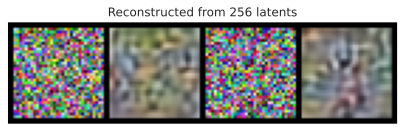

In [19]:
rng = jax.random.PRNGKey(123)
rgn, noise_rgn = jax.random.split(rng)
rand_imgs = jax.random.uniform(rng, (2, 32, 32, 3)) * 2 - 1
visualize_reconstructions(model_dict[256]["trainer"], rand_imgs)

The reconstruction of the noise is quite poor, and seems to introduce some rough patterns. As the input does not follow the patterns of the CIFAR dataset, the model has issues reconstructing it accurately.

We can also check how well the model can reconstruct other manually-coded patterns:

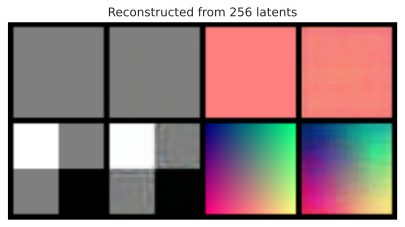

In [20]:
# JAX arrays are natively immutable. This is why we first create the images in numpy, and push them to JAX afterwards
plain_imgs = np.zeros((4, 32, 32, 3))

# Single color channel
plain_imgs[1,:,:,0] = 1 
# Checkboard pattern
plain_imgs[2,:16,:16] = 1
plain_imgs[2,16:,16:] = -1
# Color progression
xx, yy = np.meshgrid(np.linspace(-1,1,32), np.linspace(-1,1,32), indexing='ij')
plain_imgs[3,:,:,0] = xx
plain_imgs[3,:,:,1] = yy

visualize_reconstructions(model_dict[256]["trainer"], plain_imgs)

The plain, constant images are reconstructed relatively good although the single color channel contains some noticeable noise. The hard borders of the checkboard pattern are not as sharp as intended, as well as the color progression, both because such patterns never occur in the real-world pictures of CIFAR.

In general, autoencoders tend to fail reconstructing high-frequent noise (i.e. sudden, big changes across few pixels) due to the choice of MSE as loss function (see our previous discussion about loss functions in autoencoders). Small misalignments in the decoder can lead to huge losses so that the model settles for the expected value/mean in these regions. For low-frequent noise, a misalignment of a few pixels does not result in a big difference to the original image. However, the larger the latent dimensionality becomes, the more of this high-frequent noise can be accurately reconstructed. 

### Generating new images

Variational autoencoders are a generative version of the autoencoders because we regularize the latent space to follow a Gaussian distribution. However, in vanilla autoencoders, we do not have any restrictions on the latent vector. So what happens if we would actually input a randomly sampled latent vector into the decoder? Let's find it out below:

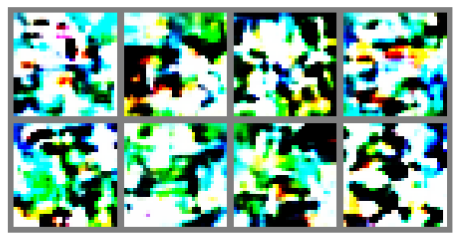

In [21]:
trainer = model_dict[256]["trainer"]
rgn, latent_noise = jax.random.split(rng)
latent_vectors = jax.random.normal(latent_noise, (8, trainer.latent_dim))
# Decode images -> Run model.decode method of the trainer's model with given parameters
imgs = trainer.model_bd.decoder(latent_vectors) # nn.apply(lambda model: model.decode(latent_vectors), trainer.model)({'params': trainer.state.params})

imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

As we can see, the generated images more look like art than realistic images. As the autoencoder was allowed to structure the latent space in whichever way it suits the reconstruction best, there is no incentive to map every possible latent vector to realistic images. Furthermore, the distribution in latent space is unknown to us and doesn't necessarily follow a multivariate normal distribution. Thus, we can conclude that vanilla autoencoders are indeed not generative.

## Finding visually similar images

One application of autoencoders is to build an image-based search engine to retrieve visually similar images. This can be done by representing all images as their latent dimensionality, and find the closest $K$ images in this domain. The first step to such a search engine is to encode all images into $z$. In the following, we will use the training set as a search corpus, and the test set as queries to the system.

<div class="alert alert-warning">

**Warning:** the following cells can be computationally heavy for a weak CPU-only system. If you do not have a strong computer and are not on Google Colab, you might want to skip the execution of the following cells and rely on the results shown in the filled notebook.
</div>

In [22]:
# We use the following model throughout this section. 
# If you want to try a different latent dimensionality, change it here!
trainer = model_dict[128]["trainer"] 

In [23]:
def embed_imgs(trainer, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    
    @jax.jit
    def encode(imgs):
        return trainer.model_bd.encoder(imgs)
    
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        z = encode(imgs)
        z = jax.device_get(z)
        imgs = jax.device_get(imgs)
        img_list.append(imgs)
        embed_list.append(z)
    return (np.concatenate(img_list, axis=0), np.concatenate(embed_list, axis=0))

train_img_embeds = embed_imgs(trainer, train_loader)
test_img_embeds = embed_imgs(trainer, test_loader)


Encoding images:   0%|          | 0/175 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/40 [00:00<?, ?it/s]

After encoding all images, we just need to write a function that finds the closest $K$ images and returns (or plots) those:

In [24]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = np.linalg.norm(query_z[None,:] - key_embeds[1], axis=-1)
    indices = np.argsort(dist)
    dist = dist[indices]
    # Plot K closest images
    imgs_to_display = np.concatenate([query_img[None], key_embeds[0][indices[:K]]], axis=0)
    imgs_to_display = torch.from_numpy(imgs_to_display)
    imgs_to_display = imgs_to_display.permute(0, 3, 1, 2)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

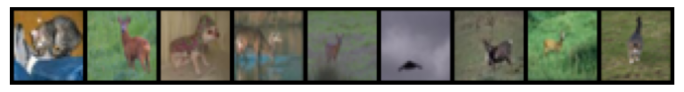

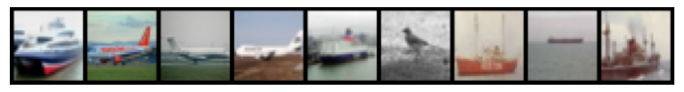

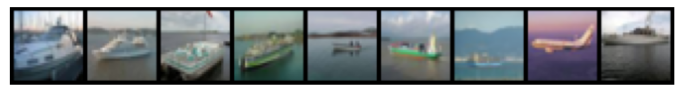

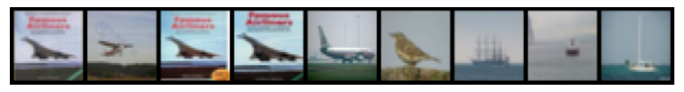

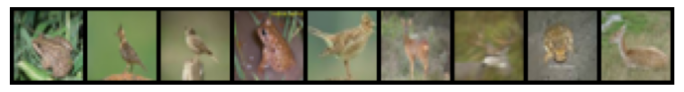

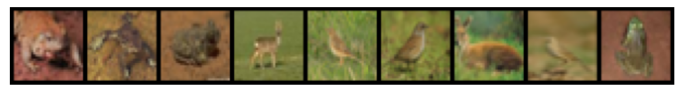

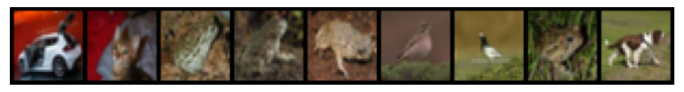

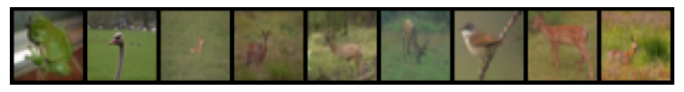

In [25]:
# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

Based on our autoencoder, we see that we are able to retrieve many similar images to the test input. In particular, in row 4, we can spot that some test images might not be that different from the training set as we thought (same poster, just different scaling/color scaling). We also see that although we haven't given the model any labels, it can cluster different classes in different parts of the latent space (airplane + ship, animals, etc.). This is why autoencoders can also be used as a pre-training strategy for deep networks, especially when we have a large set of unlabeled images (often the case). However, it should be noted that the background still plays a big role in autoencoders while it doesn't for classification. Hence, we don't get "perfect" clusters and need to finetune such models for classification.

### Tensorboard clustering

Another way of exploring the similarity of images in the latent space is by dimensionality-reduction methods like PCA or T-SNE. Luckily, Tensorboard provides a nice interface for this and we can make use of it in the following:

In [26]:
# We use the following model throughout this section. 
# If you want to try a different latent dimensionality, change it here!
trainer = model_dict[128]["trainer"]

In [27]:
# Create a summary writer
writer = SummaryWriter("tensorboard/")

The function `add_embedding` allows us to add high-dimensional feature vectors to TensorBoard on which we can perform clustering. What we have to provide in the function are the feature vectors, additional metadata such as the labels, and the original images so that we can identify a specific image in the clustering. 

In [28]:
## In case you obtain the following error in the next cell, execute the import statements and last line in this cell
##   AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [29]:
# Note: the embedding projector in tensorboard is computationally heavy.
# Reduce the image amount below if your computer struggles with visualizing all 10k points
NUM_IMGS = len(test_set) 

writer.add_embedding(test_img_embeds[1][:NUM_IMGS], # Encodings per image
                     metadata=[test_set[i][1] for i in range(NUM_IMGS)], # Adding the labels per image to the plot
                     label_img=torch.from_numpy(test_img_embeds[0][:NUM_IMGS]+1).permute(0, 3, 1, 2)/2.0) # Adding the original images to the plot

Finally, we can run tensorboard to explore similarities among images:

In [30]:
%tensorboard --logdir tensorboard/

You should be able to see something similar as in the following image. In case the projector stays empty, try to start the TensorBoard outside of the Jupyter notebook.

<center><img src="../../tutorial9/tensorboard_projector_screenshot.jpeg" width="70%"/></center>

Overall, we can see that the model indeed clustered images together that are visually similar. Especially the background color seems to be a crucial factor in the encoding. This correlates to the chosen loss function, here Mean Squared Error on pixel-level because the background is responsible for more than half of the pixels in an average image. Hence, the model learns to focus on it. Nevertheless, we can see that the encodings also separate a couple of classes in the latent space although it hasn't seen any labels. This shows again that autoencoding can also be used as a "pre-training"/transfer learning task before classification.

In [31]:
# Closing the summary writer
writer.close()

## Conclusion

In this tutorial, we have implemented our own autoencoder on small RGB images and explored various properties of the model. In contrast to variational autoencoders, vanilla AEs are not generative and can work on MSE loss functions. This makes them often easier to train. Both versions of AE can be used for dimensionality reduction, as we have seen for finding visually similar images beyond pixel distances. Despite autoencoders gaining less interest in the research community due to their more "theoretically" challenging counterpart of VAEs, autoencoders still find usage in a lot of applications like denoising and compression. Hence, AEs are an essential tool that every Deep Learning engineer/researcher should be familiar with.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---